# Analysis of locus variation across mtb complex

These methods were used to analyse the RD900 locus. Assumes the sequence region chosen as reference is the 'complete' version relative to the others. Will not detect insertions.

## How to make a reference sequence for a region in the genome

* go to the genbank nucelotide record for the genome e.g. https://www.ncbi.nlm.nih.gov/nuccore/FR878060.1?report=graph
* click on the Graphics view
* find your region. you can search by gene but it may not always work
* download the fasta and genbank files from the download button on the left. use 'visible range'
* you may have to rename the fasta file header to work nicely with snpgenie, make it something short. also rename the LOCUS and ACCESSION names in the genbank file to match this.

### example for the MAF file used here:

```
>MAF_TBD1 GM041182
CTGGTTCGGATCGGCACCGCGCGCGATGGTGATTCAGGTTCGCGGCCGCCGGGTACCCGCTCGCGCGGTC
CTTGCTGGGCACTACGCGGCATGGCTGGTGGTTTCGGTGATCGTTGCCTGGATGGTGCTGTCATGACTCC
CTCGACATCGGATGCCAGGTCGCGCCGACGCTCGGCGGAGCCCTTCCTGTGGCTGCTGTTCAGCGCCGGG


LOCUS       MAF_TBD1                5756 bp    DNA     linear   BCT 03-APR-2015
DEFINITION  Mycobacterium africanum GM041182 TBD1 locus.
ACCESSION   MAF_TBD1 REGION: 1764053..1769808
```

## find SNPs (snpgenie)

* align samples to a suitable reference locus e.g. MAF TBD1
* call variants
* build tree from snps

## find region deletions 

* use same alignments as above to calculate coverage across the locus
* or view in IGV

## Links

* [MAF GM041182 genome](https://www.ncbi.nlm.nih.gov/nuccore/FR878060.1?report=graph)

In [ ]:
from IPython.display import Image
Image(filename = "tbd1_locus.png", width=600)

In [2]:
import os, io, glob, subprocess
from importlib import reload
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from BCBio import GFF
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from snipgenie import tools, aligners, app, trees, plotting

In [21]:
read_data = pd.read_csv('../genomes_data.csv')
path = '/storage/elena_data'
read_data[-5:]

,ACCESSION,PAIRED,LINEAGE,ORIGIN,BIOPROJECT,BIOSAMPLE,Reads lenght (bp),LINK1,LINK2,REFERENCE
76,ERR4192405,yes,M. tuberculosis L9,Somalia,PRJEB38656,SAMEA6872244,101,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR419/005/...,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR419/005/...,"Swiss Tropical and Public Health Institute, Sw..."
77,ERR4192384,yes,M. tuberculosis L9,Europe,PRJEB38656,SAMEA6872223,101,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR419/004/...,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR419/004/...,"Swiss Tropical and Public Health Institute, Sw..."
78,ERR4162024,yes,M. tuberculosis L9,Somalia,PRJEB38317,SAMEA6847637,35-151,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR416/004/...,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR416/004/...,"Swiss Tropical and Public Health Institute, Sw..."
79,SRR3647355,yes,BCG-26,NaN,PRJNA270004,SAMN03253093,NaN,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR364/005/...,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR364/005/...,pda|big_chen_group
80,ERR234151,yes,M. tuberculosis L6,NaN,PRJEB3223,SAMEA1877109,NaN,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR234/ERR2...,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR234/ERR2...,"Center for Public Health Research, University ..."


## load locus features

In [4]:
rec = list(SeqIO.parse('MAF_GM041182_TBD1.gb',format='gb'))[0]
#remove gene features for plotting
rec.features = [f for f in rec.features if f.type!='gene' ]
#rec.features

## run snpgenie against reference sequence

In [22]:
args = {'threads':20, 'outdir': 'snpgenie_results', 'labelsep':'-',  
        'input':['/storage/elena_data/'],        
        'reference': 'MAF_GM041182_TBD1.fa', 'gb_file':'MAF_GM041182_TBD1.gb',
        'overwrite':False,
        'filters' : 'QUAL>=30 && FORMAT/DP>=30 && DP4>=4 && MQ>35'
        }
W = app.WorkFlow(**args)
st = W.setup()
W.run()

The following options were supplied
-------
threads : 20
outdir : snpgenie_results
labelsep : -
input : ['/storage/elena_data/']
reference : MAF_GM041182_TBD1.fa
gb_file : MAF_GM041182_TBD1.gb
overwrite : False
filters : QUAL>=30 && FORMAT/DP>=30 && DP4>=4 && MQ>35
trim : False
quality : 25
aligner : bwa
species : None
custom_filters : False
mask : None
omit_samples : []
buildtree : False
bootstraps : 100

81 samples were loaded:
----------------------
             name      sample                                   filename  pair  read_length
0    ERR4192383_1  ERR4192383  /storage/elena_data/ERR4192383_1.fastq.gz     1          101
1     ERR125602_2   ERR125602   /storage/elena_data/ERR125602_2.fastq.gz     1           70
2      ERR1200640  ERR1200640    /storage/elena_data/ERR1200640.fastq.gz     1           51
3     ERR400386_2   ERR400386   /storage/elena_data/ERR400386_2.fastq.gz     1          100
4     ERR552526_1   ERR552526   /storage/elena_data/ERR552526_1.fastq.gz     1     

In [23]:
samples = pd.read_csv('snpgenie_results/summary.csv')
samples = samples.merge(read_data,left_on='sample',right_on='ACCESSION')
samples = samples.sort_values('LINEAGE')

# snps

In [24]:
c = app.read_csq_file('snpgenie_results/csq.tsv')
#include only snps or also indels?
c=c[c.snp_type!='synonymous']
muts = list(c.aa.dropna().unique())
#muts

In [29]:
X=pd.read_csv('snpgenie_results/csq.matrix')
X = X[X.aa.isin(muts)]
X=X.set_index(['gene','aa','start','snp_type']).sort_index()

labelmap = dict(zip(samples.ACCESSION,samples.LINEAGE))
X=X.rename(columns=labelmap)
#X

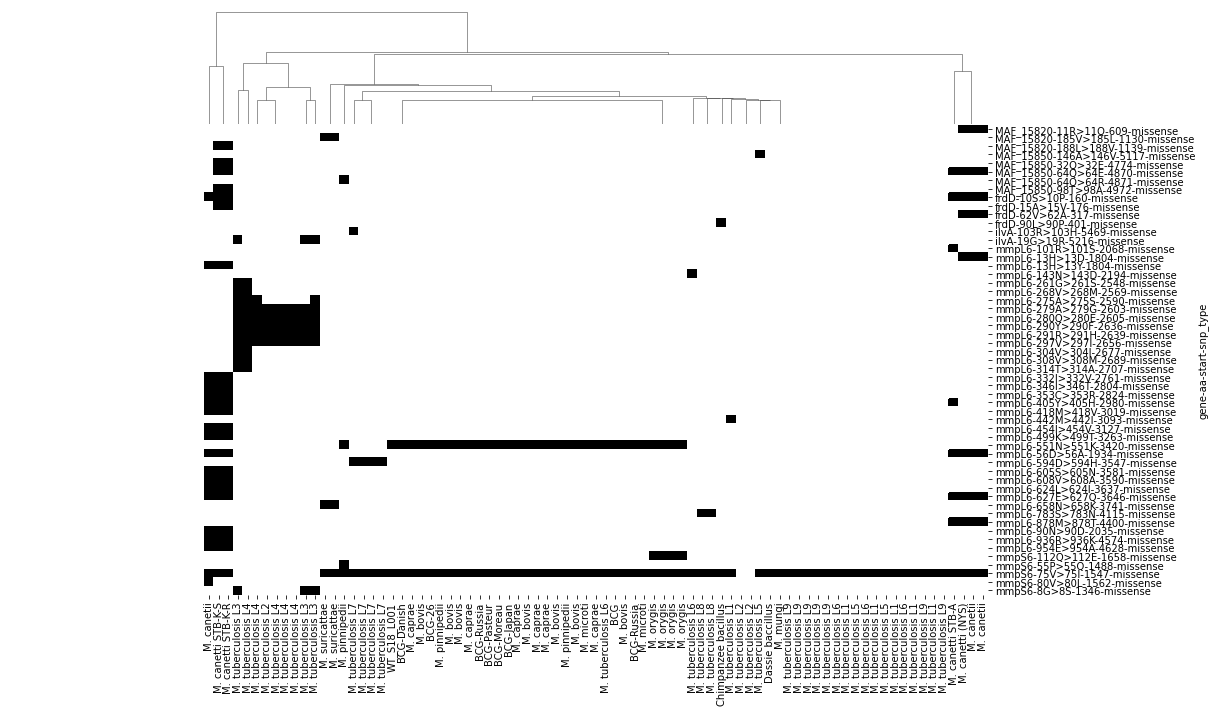

In [31]:
cm=sns.clustermap(X,row_cluster=False,cmap='gray_r',figsize=(17,10),
                  xticklabels=True,yticklabels=True)
cm.cax.set_visible(False)

## phylogeny based on snps

In [33]:
trees.run_RAXML('snpgenie_results/core.fa',outpath='temp')

raxmlHPC-PTHREADS -f a -N 100 -T 8 -m GTRCAT -V -p 92787865 -x 56388780 -n variants -w /home/farrell/gitprojects/mtbc_analyses/tbd1/temp -s snpgenie_results/core.fa


'/home/farrell/gitprojects/mtbc_analyses/tbd1/temp/RAxML_bipartitions.variants'

In [ ]:
reload(trees)
colormap = trees.colors_from_labels(samples,'ACCESSION','LINEAGE')
labelmap = dict(zip(samples.ACCESSION,samples.LINEAGE))
tree,ts = trees.create_tree('temp/RAxML_bestTree.variants',None,labelmap,colormap)
names=['M. canetti STB-K-S','M. canetti STB-K-R']
trees.remove_nodes(tree, names)

ts.scale = 5000
#ts.mode = 'c'
ts.margin_left = 10
ts.branch_vertical_margin = 1
#ts.force_topology = True
tree.render('%%inline',tree_style=ts,w=400)

# detect deletions

We can do this visually or automate it

In [35]:
def get_coverage(bam_file, chr, start, end, ref):
    cmd = 'samtools mpileup {b} --min-MQ 10 -f {r} -r {c}:{s}-{e}'.format(c=chr,s=start,e=end,b=bam_file,r=ref)
    #print(cmd)
    temp = subprocess.check_output(cmd, shell=True)    
    df=pd.read_csv(io.BytesIO(temp), sep='\t', names=['chr','pos','base','coverage','q','c'])
    return df


## show coverage

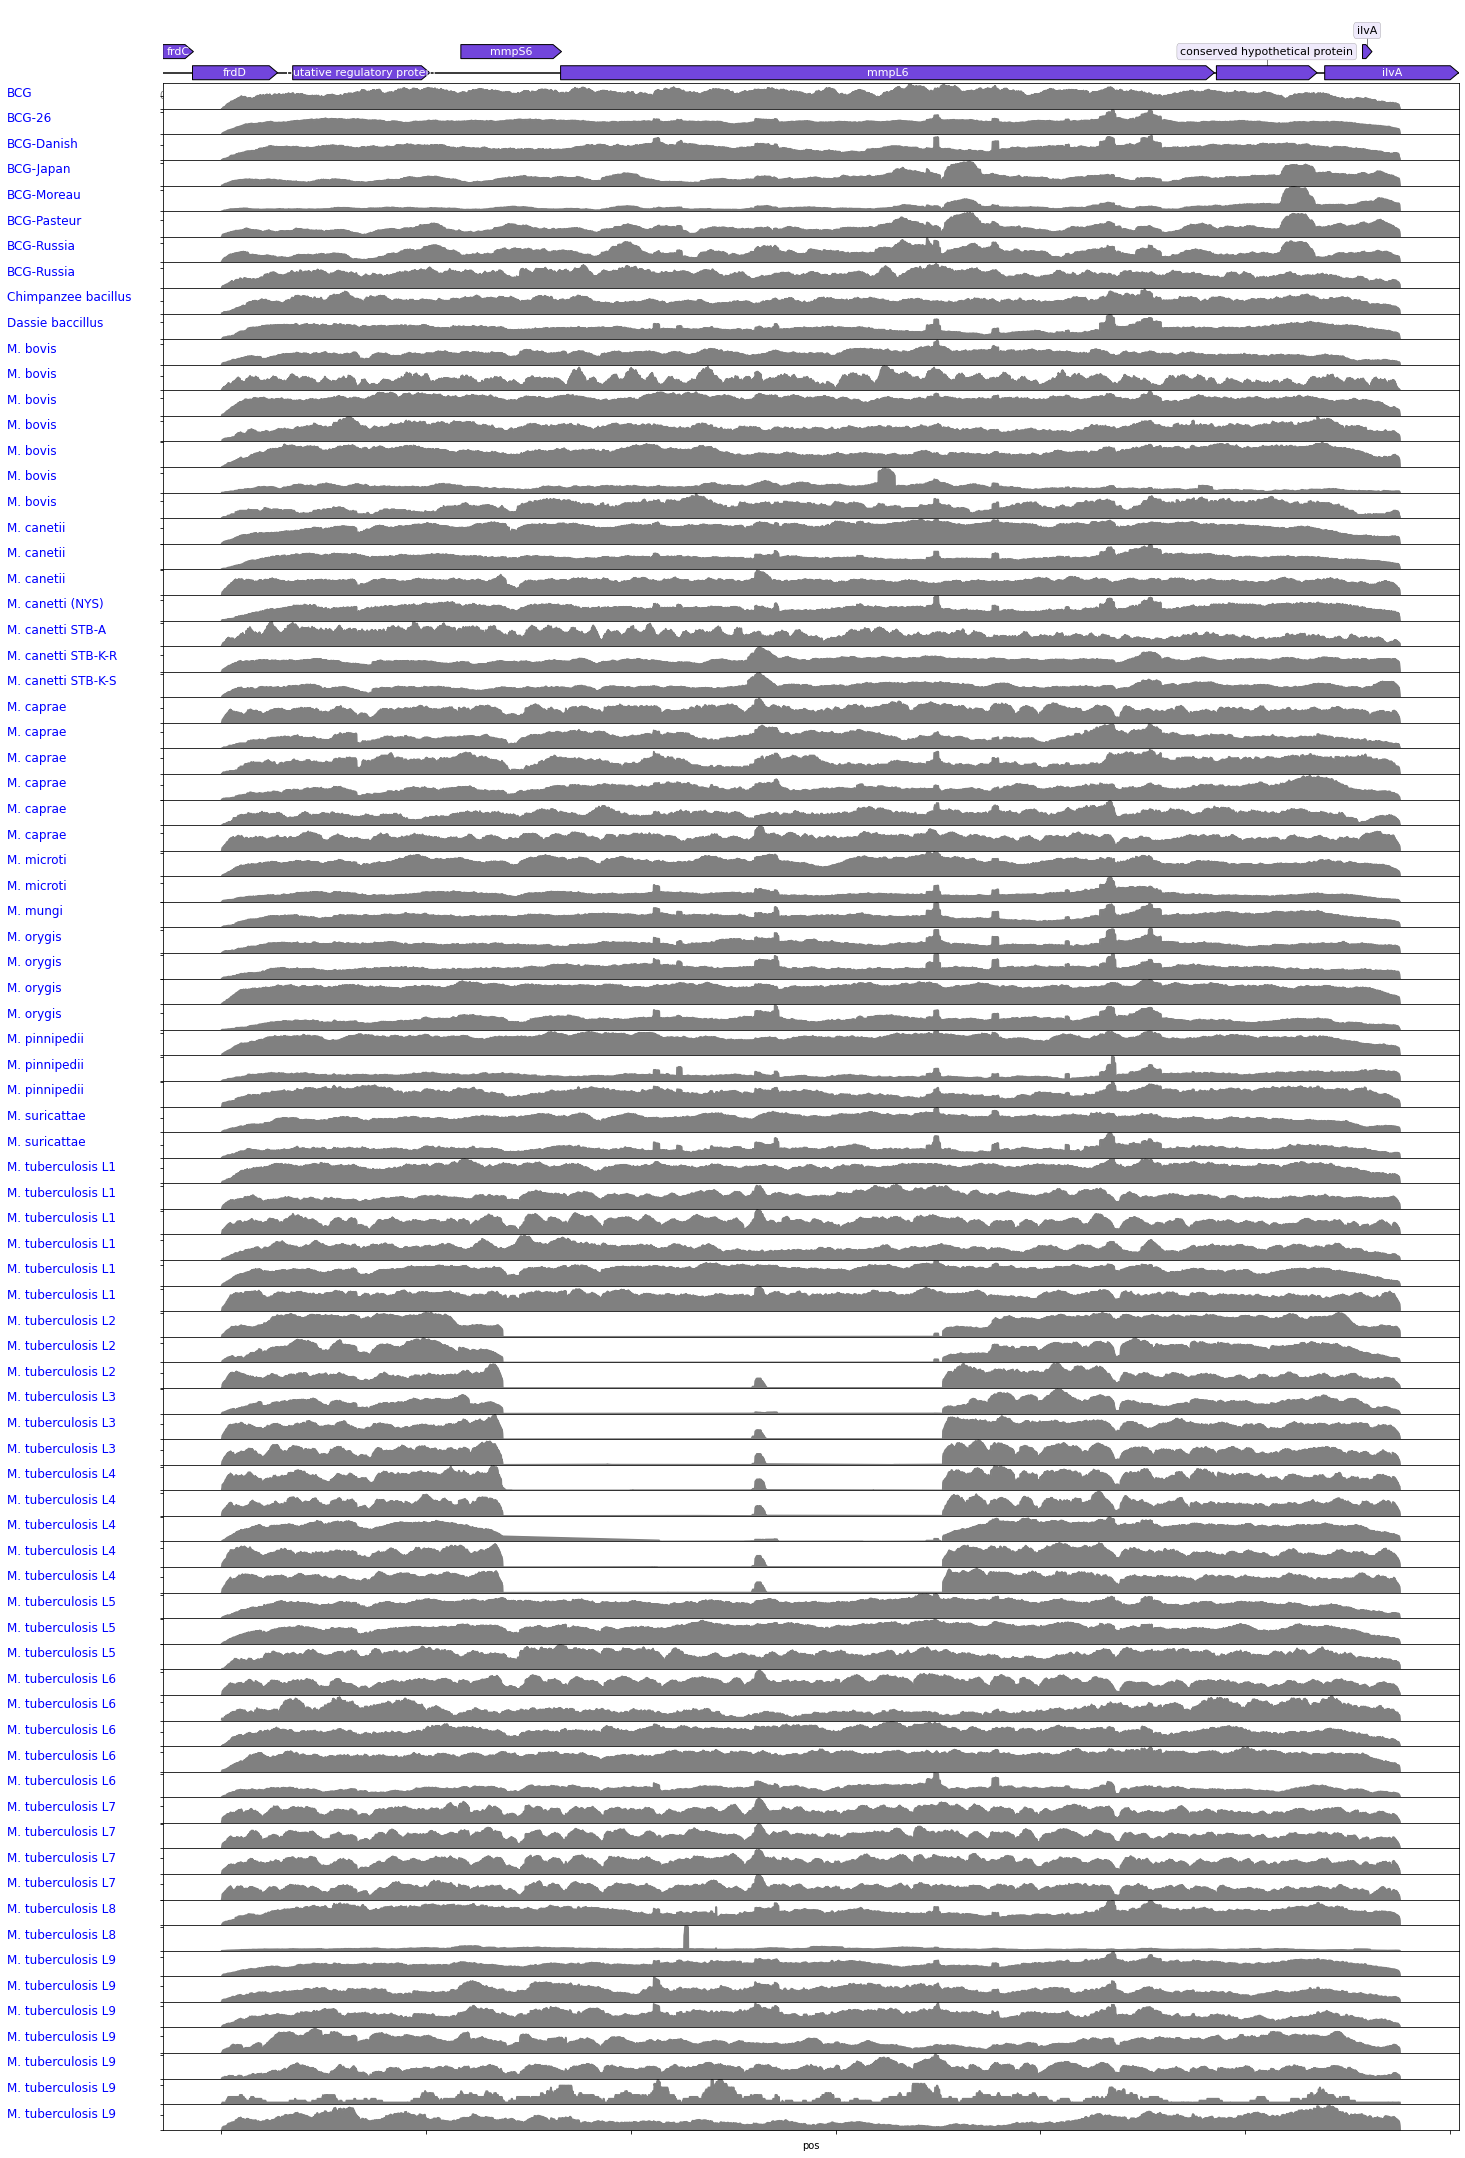

In [40]:
from dna_features_viewer import GraphicFeature, GraphicRecord
from dna_features_viewer import BiopythonTranslator

graphic_record = BiopythonTranslator().translate_record(rec)
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(30,40))
gs = GridSpec(len(samples)+5, 1, figure=fig)
ax1=fig.add_subplot(gs[:3,0])
graphic_record.plot(ax=ax1)
i=3
for n,r in list(samples.iterrows()):#[40:60]:
    ax=fig.add_subplot(gs[i,0])
    df = get_coverage(r.bam_file,'MAF_TBD1',1,len(rec.seq),'MAF_GM041182_TBD1.fa')
    #bins=range(0,max(df.coverage),int(max(df.coverage)/10))
    #df['binned']=np.searchsorted(bins, df.coverage.values)
    df.plot(x='pos',y='coverage',ax=ax,kind='area',color='gray',legend=False)
    label=r.LINEAGE
    ax.text(-.12,.5,label,color='blue',transform=ax.transAxes,fontsize=12)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    i+=1
plt.subplots_adjust(left=.3,right=.9,wspace=0, hspace=0)

## other mmpL proteins

In [31]:
ref = tools.genbank_to_dataframe('GM041182.gb')
ref = ref[ref.feat_type=='CDS']

In [50]:
mmpl = ref[ref.gene.fillna('').str.contains('mmpL')]
mmpl

,gene,locus_tag,inference,id,start,end,strand,feat_type,sequence
473,mmpL11,MAF_02030,NaN,FR878060.1,235045,237946,-1,CDS,ATGATGCGCTTGAGCCGCAACCTGCGCAGGTGCCGTTGGTTGGTCT...
481,mmpL3,MAF_02070,NaN,FR878060.1,241137,243972,-1,CDS,GTGTTCGCCTGGTGGGGTCGAACTGTGTACCGCTACCGGTTCATCG...
932,mmpL1,MAF_04040,NaN,FR878060.1,477091,479968,-1,CDS,GTGAGGAGCCAACGTCTAGCCGGGCACCTGTCGGCCGCCGCCCGGA...
1045,mmpL4,MAF_04520,NaN,FR878060.1,535309,538213,-1,CDS,GTGAGTACTAAATTCGCGAACGACTCCAATACCAACGCTCGCCCCG...
1179,mmpL2,MAF_05140,NaN,FR878060.1,593958,596865,1,CDS,ATGAGCGAAAGACACGCCGCACTGACGTCACTGCCGCCCATTCTGC...
1582,mmpL5,MAF_06850,NaN,FR878060.1,772974,775869,-1,CDS,ATGATCGTGCAAAGGACAGCTGCGCCGACGGGCTCCGTCCCGCCCG...
2710,mmpL13a,MAF_11620,NaN,FR878060.1,1269797,1270709,1,CDS,ATGCTGCAGAGGATCGCTCGGCTCGCCATCGCTGCGCCGCGCCGAA...
2712,mmpL13b,MAF_11630,NaN,FR878060.1,1270730,1272143,1,CDS,GTGGCTACCGTGGCATTCGTCGCGACCGCGTCGATCGTGATCACCC...
2803,mmpL10,MAF_12020,NaN,FR878060.1,1320251,1323260,1,CDS,GTGGTCGGCTGTTGGGTCGCGCTCGCCCTGGTACTGCCGATGGCGG...
3646,mmpL12,MAF_15490,NaN,FR878060.1,1717802,1721243,-1,CDS,GTGGCAAGGCATGACGAGGCCAAAGCCGGGGGACTGTTCGACCGTA...


## run snipgenie against entire genome

In [ ]:
args = {'threads':22, 'outdir': '/storage/mtbc_maf_snp_results', 'labelsep':'-',  
        'input':['/storage/elena_data/'],        
        'reference': 'GM041182.fna', 'gb_file':'GM041182.gb',
        'overwrite':False
        }
W = app.WorkFlow(**args)
st = W.setup()
W.run()

## find snps in arbitary regions

In [ ]:
X=pd.read_csv('/storage/mtbc_maf_snp_results/csq.matrix')
X = X.set_index(['gene','aa','start']).sort_index()
X=X.drop(columns=['ERR1109376','ERR1109377'])
X=X[X.sum(1)>0]
labelmap = dict(zip(samples.ACCESSION,samples.LINEAGE))
X=X.rename(columns=labelmap)
X=X.loc[mmpl.gene]


In [ ]:
cm=sns.clustermap(X,row_cluster=True,cmap='gray_r',figsize=(14,15),
                  xticklabels=True,yticklabels=[])
cm.cax.set_visible(False)

In [84]:
c = app.read_csq_file('/storage/mtbc_maf_snp_results/csq.tsv')
#include only snps or also indels?
c=c[c.snp_type!='synonymous']

In [ ]:
m=c[c.gene.isin(mmpl.gene)]
m=m.merge(samples,on='sample',how='left')
